In [14]:
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import gaussian_blur
import os
import numpy as np
from PIL import Image
import random
import matplotlib.pyplot as plt

Extracting data

In [21]:
from torch.utils.data import ConcatDataset

class HDF5KeyImageDataset(Dataset):
    def __init__(self, cdm_path, wdm_path, transform=None):
        self.transform = transform

        self.data_sources = []  # List of (file_type, key_name, sub_index_if_needed)
        
        # Load CDM keys
        self.cdm_file = h5py.File(cdm_path, 'r')
        for key in self.cdm_file.keys():
            self.data_sources.append(('cdm', key, None))

        # Load WDM keys
        self.wdm_file = h5py.File(wdm_path, 'r')
        for key in self.wdm_file.keys():
            self.data_sources.append(('wdm', key, None))


    def __len__(self):
        return len(self.data_sources)

    def __getitem__(self, idx):
        source, key, sub_idx = self.data_sources[idx]
        h5_file = self.cdm_file if source == 'cdm' else self.wdm_file
        label = 0 if source == 'cdm' else 1
    
        arr = h5_file[key]
        img = arr[:] if sub_idx is None else arr[sub_idx]
    
        # Clean + normalize
        img = np.nan_to_num(img, nan=0.0, posinf=1.0, neginf=0.0)
        img = np.clip(img, 0, None)  # Ensure non-negative
        img = img.astype(np.float32)
    
        if img.max() > 0:
            img = img / img.max()  # Normalize to [0, 1]
    
        # Convert to torch tensor and add channel dim
        img = torch.from_numpy(img).unsqueeze(0)  # shape: [1, H, W]
    
        if self.transform:
            img = self.transform(img)
    
        return img, torch.tensor(label, dtype=torch.float32)


    def __del__(self):
        self.cdm_file.close()
        self.wdm_file.close()

def load_multiple_hdf5_datasets(indices, transform=None):
    datasets = []
    for idx in indices:
        cdm_path = f'/n/netscratch/iaifi_lab/Lab/ccuestalazaro/DREAMS/Images/CDM/MW_zooms/box_{idx}/CDM/Galaxy_{idx}.hdf5'
        wdm_path = f'/n/netscratch/iaifi_lab/Lab/ccuestalazaro/DREAMS/Images/WDM/MW_zooms/box_{idx}/CDM/Galaxy_{idx}.hdf5'
        if os.path.exists(cdm_path) and os.path.exists(wdm_path):
            ds = HDF5KeyImageDataset(cdm_path, wdm_path, transform=transform)
            datasets.append(ds)
        else:
            print(f"Skipping missing: {cdm_path} or {wdm_path}")
    return ConcatDataset(datasets)

In [73]:
WDM_mass=[]
with open('WDM_TNG_MW_SB4.txt','r') as f:
    for i, line in enumerate(f.readlines()[1:]):
        WDM_mass.append([i,float(line.strip().split(' ')[0])])

WDM_mass = np.array(WDM_mass)

k = 50
# sorted_mass = WDM_mass[WDM_mass[:,1].argsort()]
# all_indices = sorted_mass[:k,0].astype(int).tolist()

all_indices = random.sample(range(1024),k)

In [74]:
from torchvision.transforms.functional import gaussian_blur

def gaussian_blur_tensor(tensor, kernel_size=5, sigma=1.0):
    if tensor.dim() == 3:  # [C, H, W]
        tensor = tensor.unsqueeze(0)  # [1, C, H, W]
    return gaussian_blur(tensor, kernel_size=kernel_size, sigma=sigma)

class TensorAugment(nn.Module):
    def __init__(self, size=(256, 256), mean=0.5, std=0.5, p_flip=0.5, p_rot=0.5,
                 noise_std=0.01, apply_blur=False, blur_kernel=5, blur_sigma=1.0):
        super().__init__()
        self.size = size
        self.mean = mean
        self.std = std
        self.p_flip = p_flip
        self.p_rot = p_rot
        self.noise_std = noise_std
        self.apply_blur = apply_blur
        self.blur_kernel = blur_kernel
        self.blur_sigma = blur_sigma

    def forward(self, img):  # img: [1, H, W] or [H, W]
        if img.dim() == 2:
            img = img.unsqueeze(0)
        elif img.dim() == 3 and img.shape[0] != 1:
            img = img[:1]

        # Resize to 256x256
        img = F.interpolate(img.unsqueeze(0), size=self.size, mode='bilinear', align_corners=False)
        img = img.squeeze(0)  # [1, H, W]

        # Flips and rotation
        if random.random() < self.p_flip:
            img = torch.flip(img, dims=[2])  # H-flip
        if random.random() < self.p_flip:
            img = torch.flip(img, dims=[1])  # V-flip
        if random.random() < self.p_rot:
            k = random.choice([1, 2, 3])
            img = torch.rot90(img, k=k, dims=[1, 2])

        # Add noise
        noise = torch.randn_like(img) * self.noise_std
        img = img + noise

        # Optional blur
        if self.apply_blur:
            img = gaussian_blur_tensor(img, kernel_size=self.blur_kernel, sigma=self.blur_sigma).squeeze(0)

        return img

# Instantiate
transform = TensorAugment(
    size=(256, 256),
    p_flip=0.5,
    p_rot=0.5,
    noise_std=0.005,
    apply_blur=False, # Change if want to blur 
    blur_kernel=5,
    blur_sigma=1.0
)


In [75]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(42)  # Set seed for reproducible results

# Shuffle indices to randomize before splitting
random.shuffle(all_indices)

# Define split ratios (60% train, 20% val, 20% test)
train_ratio, val_ratio, test_ratio = 0.6, 0.2, 0.2
total_samples = len(all_indices)

# Calculate split indices
train_end = int(train_ratio * total_samples)
val_end = int((train_ratio + val_ratio) * total_samples)

# Create index splits
train_indices = all_indices[:train_end]
val_indices = all_indices[train_end:val_end]
test_indices = all_indices[val_end:]

# Print split information
print(f"Dataset split:")
print(f"Total samples: {total_samples} sets")
print(f"Train: {len(train_indices)} sets ({len(train_indices)/total_samples*100:.1f}%)")
print(f"Validation: {len(val_indices)} sets ({len(val_indices)/total_samples*100:.1f}%)")
print(f"Test: {len(test_indices)} sets ({len(test_indices)/total_samples*100:.1f}%)")

# Create datasets
# Training set: WITH augmentation
train_dataset = load_multiple_hdf5_datasets(train_indices, transform=transform)

# Validation and test sets: WITHOUT augmentation
val_dataset = load_multiple_hdf5_datasets(val_indices, transform=transform)
test_dataset = load_multiple_hdf5_datasets(test_indices, transform=transform)

# Create data loaders
# Use num_workers=1 or 0 based on system capabilities
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=1, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=1, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=1, pin_memory=True)

print(f"\nData loaders created:")
print(f"Train loader: {len(train_loader)} batches")
print(f"Val loader: {len(val_loader)} batches") 
print(f"Test loader: {len(test_loader)} batches")

Dataset split:
Total samples: 50 sets
Train: 30 sets (60.0%)
Validation: 10 sets (20.0%)
Test: 10 sets (20.0%)

Data loaders created:
Train loader: 644 batches
Val loader: 215 batches
Test loader: 215 batches


In [18]:
class PatchEmbed(nn.Module):
    def __init__(self, img_size=256, patch_size=16, in_chans=1, embed_dim=128):
        super().__init__()
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)                     # [B, embed_dim, H/patch, W/patch]
        x = x.flatten(2).transpose(1, 2)     # [B, N, embed_dim]
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim=128, num_heads=4, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 2),
            nn.GELU(),
            nn.Linear(embed_dim * 2, embed_dim)
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.attn_weights = None

    def forward(self, x):
        attn_out, attn_weights = self.attn(x, x, x, need_weights=True)
        self.attn_weights = attn_weights.detach()
        x = self.norm1(x + attn_out)
        x = self.norm2(x + self.ffn(x))
        return x

class SimpleViT(nn.Module):
    def __init__(self, img_size=256, patch_size=16, in_chans=1, num_classes=1,
                 embed_dim=128, depth=2, num_heads=4, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, (img_size // patch_size)**2 + 1, embed_dim))
        self.transformer = nn.ModuleList([
            TransformerEncoder(embed_dim, num_heads, dropout) for _ in range(depth)
        ])
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed[:, :x.size(1), :]
        for block in self.transformer:
            x = block(x)
        return self.head(x[:, 0])

    def get_last_attention_map(self):
        return self.transformer[-1].attn_weights  # shape: [B, heads, N, N]


In [76]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate model
model = SimpleViT(img_size=256, patch_size=16, in_chans=1, num_classes=1, embed_dim=128).to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

# Training parameters
EPOCHS = 60
patience = 10
best_val_loss = float('inf')
patience_counter = 0

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Accuracies record
train_loss_hist, train_acc_hist, val_acc_hist = [],[],[]

# Training loop
print("Starting ViT training...")
for epoch in range(EPOCHS):
    model.train()
    train_loss, train_correct = 0.0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * labels.size(0)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        train_correct += (preds == labels).sum().item()

    avg_train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)

    # Validation phase
    model.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_correct += (preds == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)
    scheduler.step(avg_val_loss)

    train_loss_hist.append(avg_train_loss)
    train_acc_hist.append(train_acc)
    val_acc_hist.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Train Acc={train_acc:.4f}, "
          f"Val Loss={avg_val_loss:.4f}, Val Acc={val_acc:.4f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_vit_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break


Starting ViT training...


KeyboardInterrupt: 

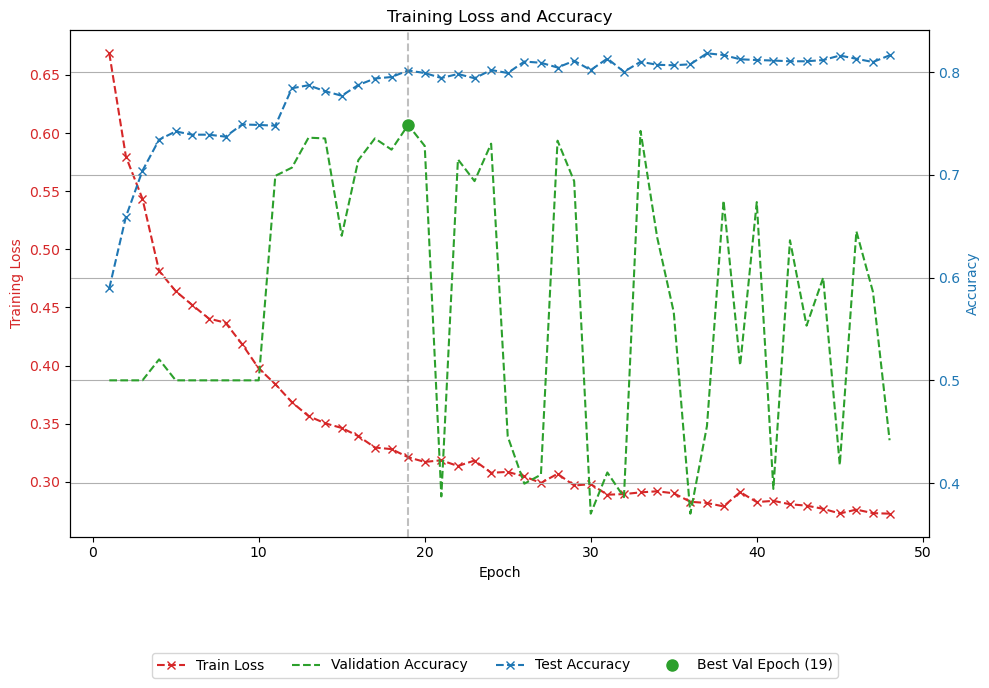

In [55]:
def plot_training_progress(train_loss, val_acc, test_acc):
    """
    Plots training loss and validation/test accuracy across epochs.
    Highlights the best epoch (highest validation accuracy).
    """
    epochs = range(1, len(train_loss) + 1)
    best_epoch = val_acc.index(max(val_acc)) + 1

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Training loss
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Training Loss", color='tab:red')
    ax1.plot(epochs, train_loss, color='tab:red', label="Train Loss", linestyle='--',marker='x')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Accuracy (val/test)
    ax2 = ax1.twinx()
    ax2.set_ylabel("Accuracy", color='tab:blue')
    ax2.plot(epochs, val_acc, label="Validation Accuracy", color='tab:green', linestyle='--')
    ax2.plot(epochs, test_acc, label="Test Accuracy", color='tab:blue', linestyle='--',marker='x')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # Highlight best validation epoch
    ax2.axvline(best_epoch, color='gray', linestyle='--', alpha=0.5)
    ax2.plot(best_epoch, val_acc[best_epoch - 1], 'o', color='tab:green', markersize=8,
             label=f"Best Val Epoch ({best_epoch})")

    # Combine legends
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    fig.legend(lines_1 + lines_2, labels_1 + labels_2,
               loc="lower center", bbox_to_anchor=(0.5, -0.15), ncol=4)

    plt.title("Training Loss and Accuracy")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('accuracy_vs_epoch_ViT.png')
    plt.show()

plot_training_progress(train_loss_hist, val_acc_hist, train_acc_hist)


In [29]:
attn_map = model.get_last_attention_map()  # shape: [B, heads, N, N]

In [67]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
import math

def plot_attention_map(attn_map, patch_size=16, img_size=256, head=0):
    """
    attn_map: [heads, N, N]
    Visualize attention from CLS token to image patches
    """
    H, N, _ = attn_map.shape
    cls_attn = attn_map[head, 0, 1:]  # CLS token's attention to all patches

    num_patches = int(math.sqrt(N - 1))
    cls_attn_grid = cls_attn.reshape(num_patches, num_patches).cpu()

    # Upsample to image size
    full_map = F.interpolate(cls_attn_grid.unsqueeze(0).unsqueeze(0),
                             size=(img_size, img_size), mode='bilinear', align_corners=False).squeeze()

    # Plot
    plt.figure(figsize=(5, 5))
    plt.imshow(full_map, cmap='viridis')
    plt.title(f"Attention Map (Head {head})")
    plt.axis('off')
    plt.colorbar()
    plt.savefig(f'att_map_{head}')
    plt.show()

import matplotlib.pyplot as plt
import torch.nn.functional as F
import math

def plot_all_attention_heads(attn_map, patch_size=16, img_size=256):
    """
    Plot CLS-token attention for all heads in a square grid.
    attn_map: [heads, N, N]
    """
    num_heads = attn_map.shape[0]
    num_patches = int(math.sqrt(attn_map.shape[1] - 1))
    grid_size = math.ceil(math.sqrt(num_heads))

    fig, axs = plt.subplots(grid_size, grid_size, figsize=(3 * grid_size, 3 * grid_size))
    axs = axs.flatten()

    for head in range(grid_size * grid_size):
        ax = axs[head]
        ax.axis('off')

        if head < num_heads:
            cls_attn = attn_map[head, 0, 1:]
            attn_grid = cls_attn.reshape(num_patches, num_patches).cpu()

            attn_img = F.interpolate(attn_grid.unsqueeze(0).unsqueeze(0),
                                     size=(img_size, img_size),
                                     mode='bilinear', align_corners=False).squeeze()

            ax.imshow(attn_img, cmap='magma')
            ax.set_title(f"Head {head}")

    plt.tight_layout()
    plt.savefig('att_head.png')
    plt.show()


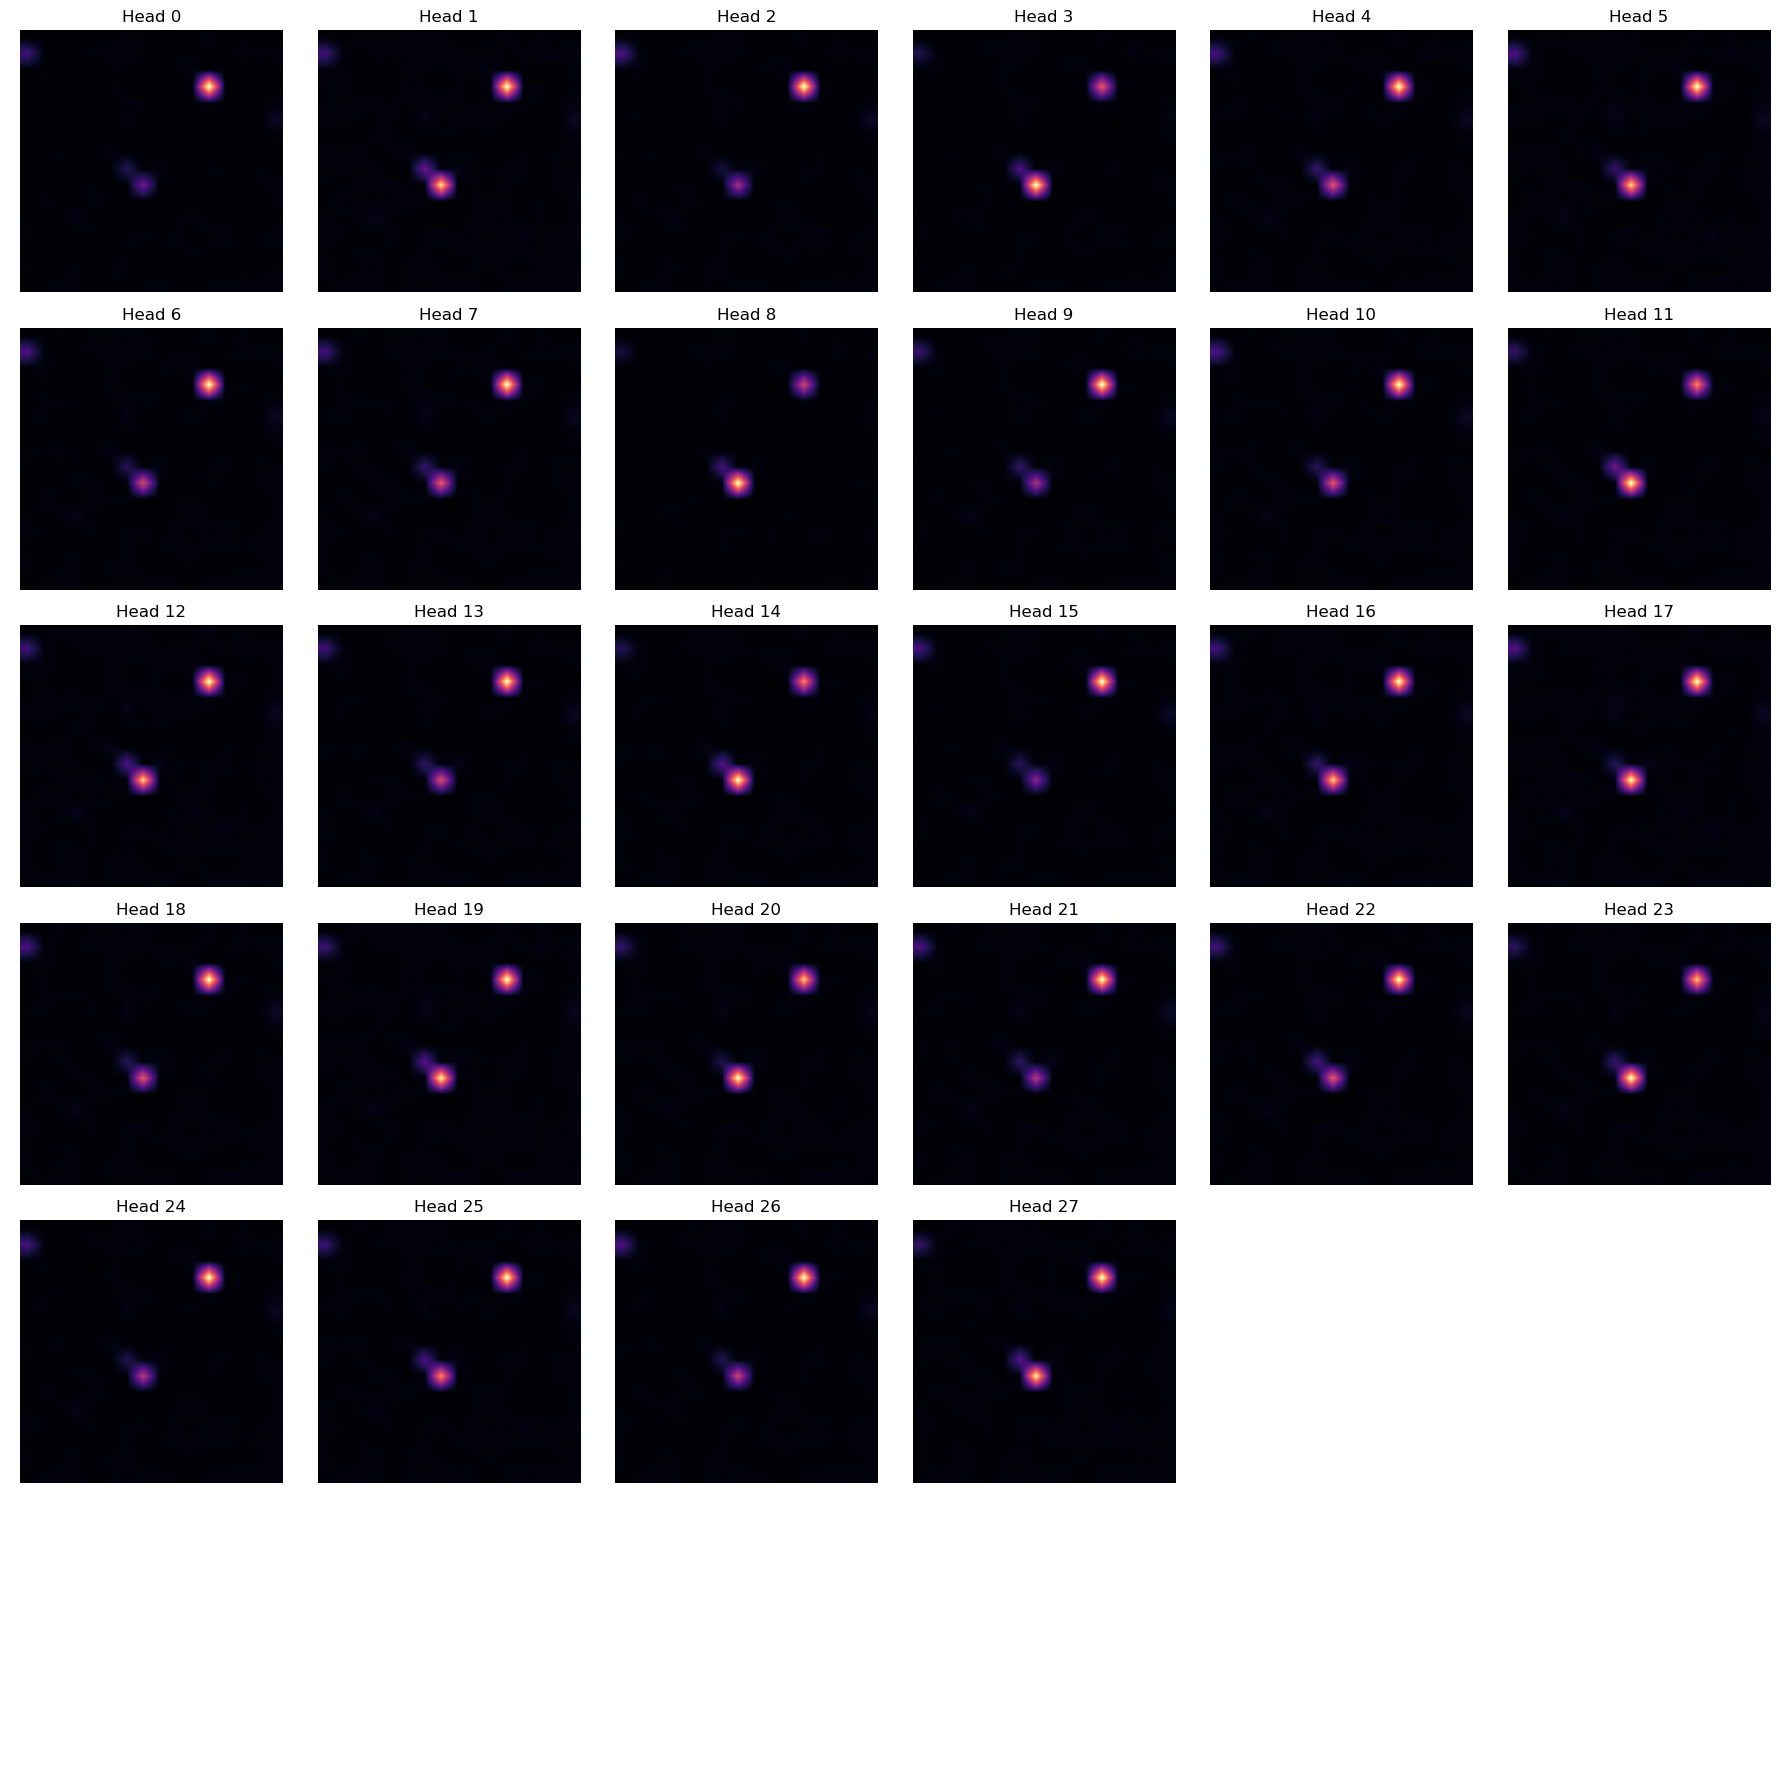

In [68]:
_ = model(images)  # Forward pass
attn_map = model.get_last_attention_map()  # shape: [heads, N, N]
# plot_attention_map(attn_map, patch_size=16, img_size=256, head=3)
plot_all_attention_heads(attn_map, patch_size=16, img_size=256)

In [39]:
import matplotlib.pyplot as plt
import torch

def show_image_grid(images_tensor, nrow=8, normalize=False):
    """
    images_tensor: torch.Tensor of shape [B, 1, H, W]
    """
    images_np = images_tensor.squeeze(1).cpu().numpy()  # [B, H, W]
    B, H, W = images_np.shape

    ncol = nrow
    nrow = (B + ncol - 1) // ncol

    fig, axs = plt.subplots(nrow, ncol, figsize=(1.5*ncol, 1.5*nrow))
    axs = axs.flatten() if nrow > 1 else [axs]

    for i in range(nrow * ncol):
        ax = axs[i]
        ax.axis('off')
        if i < B:
            img = images_np[i]
            if normalize:
                img = (img - img.min()) / (img.max() - img.min() + 1e-8)
            ax.imshow(img, cmap='gray')

    plt.tight_layout()
    plt.show()


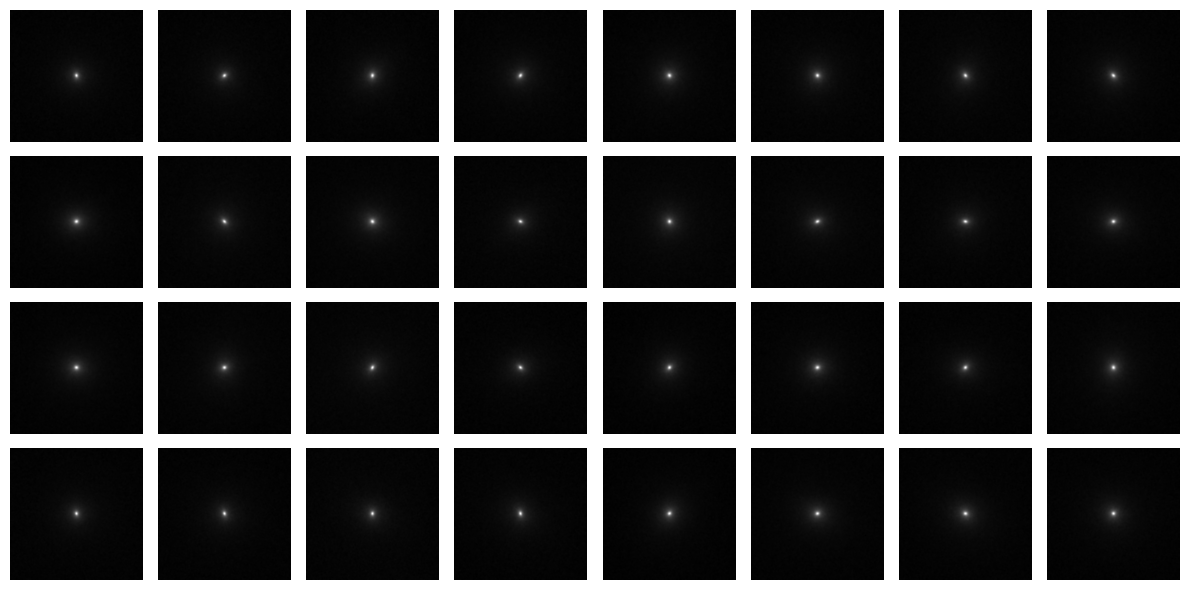

In [40]:
# assuming images has shape [32, 1, 256, 256]
show_image_grid(images, nrow=8, normalize=True)


In [71]:
def evaluate_vit_on_random_indices(model_path, transform, WDM_mass, sample_count=50):

    from collections import defaultdict

    # --- Setup ---
    indices = list(random.sample(range(1024), sample_count))
    accuracies = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load model
    model = SimpleViT(img_size=256, patch_size=16, in_chans=1, num_classes=1, embed_dim=128).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device,weights_only=True))
    model.eval()

    # --- Evaluation Loop ---
    for idx in indices:
        cdm_path = f'/n/netscratch/iaifi_lab/Lab/ccuestalazaro/DREAMS/Images/CDM/MW_zooms/box_{idx}/CDM/Galaxy_{idx}.hdf5'
        wdm_path = f'/n/netscratch/iaifi_lab/Lab/ccuestalazaro/DREAMS/Images/WDM/MW_zooms/box_{idx}/CDM/Galaxy_{idx}.hdf5'

        if not (os.path.exists(cdm_path) and os.path.exists(wdm_path)):
            print(f"Skipping missing files: {cdm_path}, {wdm_path}")
            continue

        test_dataset = HDF5KeyImageDataset(cdm_path, wdm_path, transform=transform)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device).unsqueeze(1)
                outputs = model(images)
                preds = (outputs > 0.5).float()
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        accuracy = correct / total if total > 0 else 0
        accuracies.append([int(idx), accuracy])
        print(f"Test Accuracy @ idx={idx}: {accuracy:.4f}")

    # --- Plotting Accuracy vs WDM Mass ---
    a_to_b = dict(WDM_mass)
    c_to_d = dict(accuracies)
    common_keys = set(a_to_b.keys()) & set(c_to_d.keys())
    mass_accuracy = np.array([[a_to_b[k], c_to_d[k]] for k in common_keys])

    plt.figure(figsize=(8, 5))
    plt.scatter(mass_accuracy[:,0], mass_accuracy[:,1], marker='o')
    plt.xlabel('WDM Mass (eV?)')
    plt.ylabel('Accuracy')
    plt.title('ViT Accuracy vs WDM Mass')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('accuracy_vs_mass_vit.png', dpi=300)
    plt.show()

    return mass_accuracy, accuracies


/tmp/ipykernel_3969162/838153164.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Test Accuracy @ idx=833: 0.5000
Test Accuracy @ idx=582: 0.5000
Test Accuracy @ idx=883: 0.2522
Test Accuracy @ idx=275: 0.2857
Test Accuracy @ idx=417: 0.4242
Test Accuracy @ idx=92: 0.4606
Test Accuracy @ idx=840: 0.6370
Test Accuracy @ idx=893: 0.3630
Test Accuracy @ idx=549: 0.5598
Test Accuracy @ idx=850: 0.9184
Test Accuracy @ idx=803: 0.5000
Test Accuracy @ idx=495: 0.5000
Test Accuracy @ idx=733: 0.5671
Test Accuracy @ idx=349: 0.6851
Test Accuracy @ idx=10: 0.5758
Test Accuracy @ idx=504: 0.5000
Test Accuracy @ idx=18: 0.5000
Test Accuracy @ idx=818: 1.0000
Test Accuracy @ idx=105: 0.5000
Test Accuracy @ idx=917: 0.5000
Test Accuracy @ idx=863: 0.5000
Test Accuracy @ idx=243: 0.5000
Test Accuracy @ idx=615: 0.5000
Test Accuracy @ idx=303: 0.5000
Test Accuracy @ idx=490: 0.5000
Test Accuracy @ idx=668: 1.0000
Test Accuracy @ idx=455: 0.5000
Test Accuracy @ idx=628: 1.0000
Test Accuracy @ idx=732: 0.5000
Test Accuracy @ idx=918: 0.3222
Test Accuracy @ idx=328: 0.0437
Test Accura

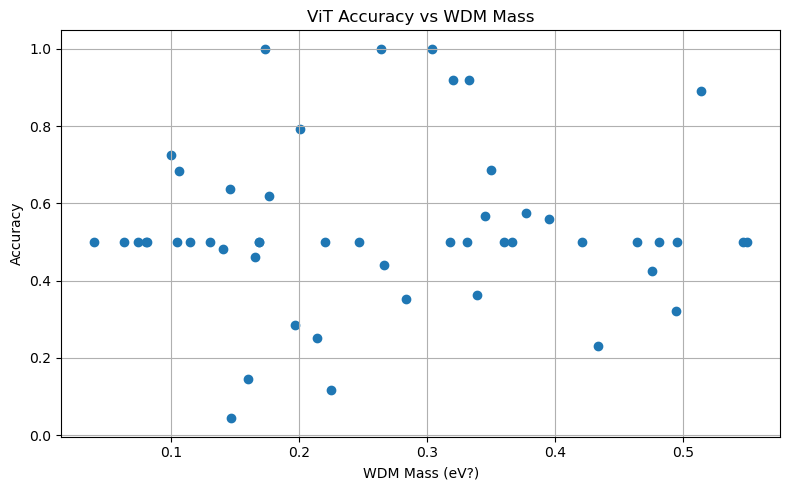

In [70]:
mass_accuracy, accuracies = evaluate_vit_on_random_indices(
    model_path='best_vit_model.pt',   # path to your trained ViT weights
    transform=transform,              # your preprocessing pipeline
    WDM_mass=WDM_mass,                # array of [index, mass]
    sample_count=50                   # or another number
)


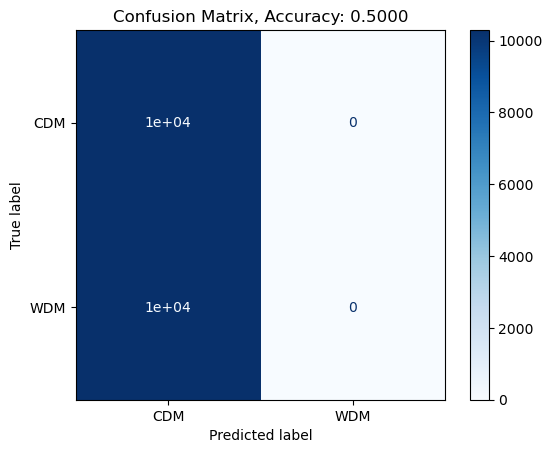

In [78]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

true_labels = []
predicted_labels = []
correct = 0
total = 0
attention_maps = []
example_images = []

model.eval()
with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).unsqueeze(1)
        
        outputs = model(images)
        preds = (outputs > 0.5).float()

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

        # Save one batch's attention maps and images for visualization
        if len(attention_maps) == 0:
            _ = model(images)
            attn = model.get_last_attention_map().cpu()  # [heads, N, N]
            attention_maps.append(attn)
            example_images.append(images.cpu())

accuracy = correct / total

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(cm, display_labels=["CDM", "WDM"])
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix, Accuracy: {accuracy:.4f}')
plt.savefig('confusion.png')
plt.show()
